线性模型组合后仍然是线性模型，因此任意层的全连接神经网络和单层神经网络模型的表达能力没有任何区别，其解决问题的能力是有限的，无法通过直线（或者高维空间的平面）划分。这也是为什么深度学习要强调非线性（通过激活函数实现非线性），可以解决更多的问题
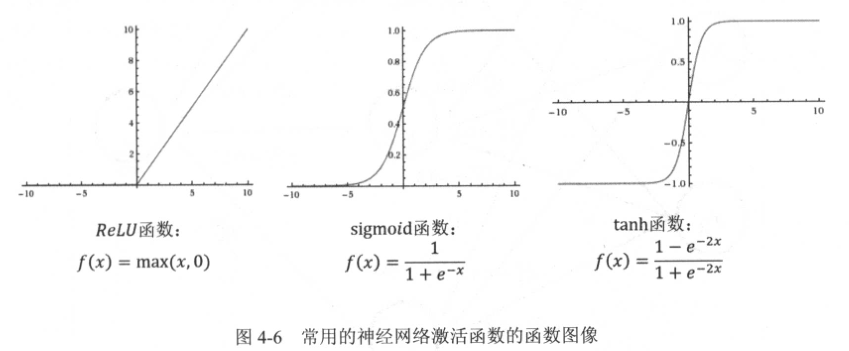

In [11]:
import tensorflow as tf

使用Tensorflow定义使用了激活函数和偏置项的神经网络
```
a = tf.nn.relu(tf.matmul(x, w1) + biases1)
y = tf.nn.relu(tf.matmul(a, w2) + biases2)
```

# 交叉熵 - 分类问题

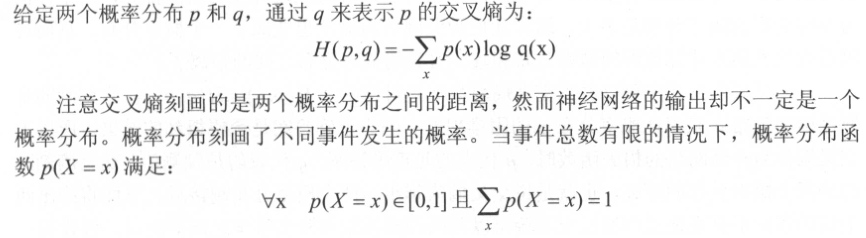

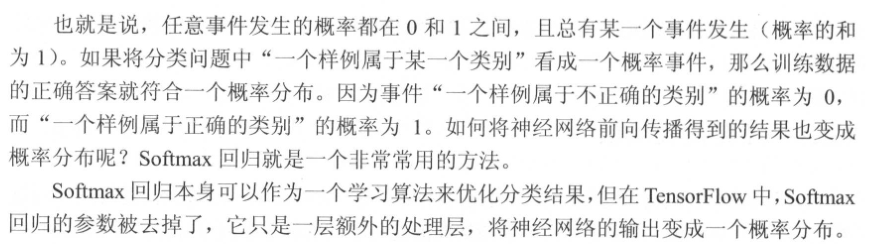

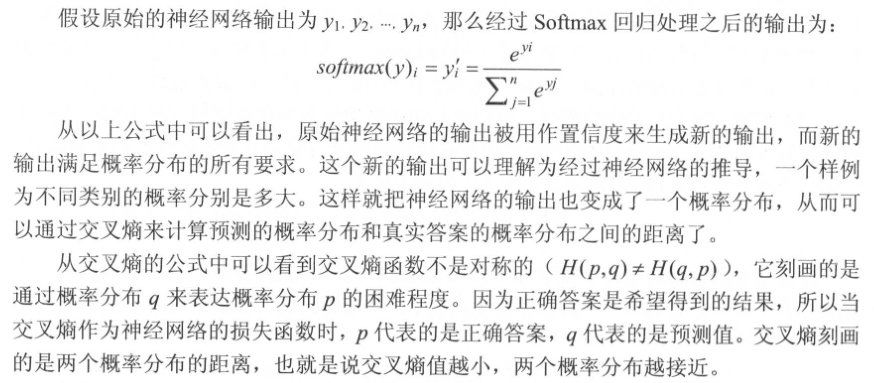

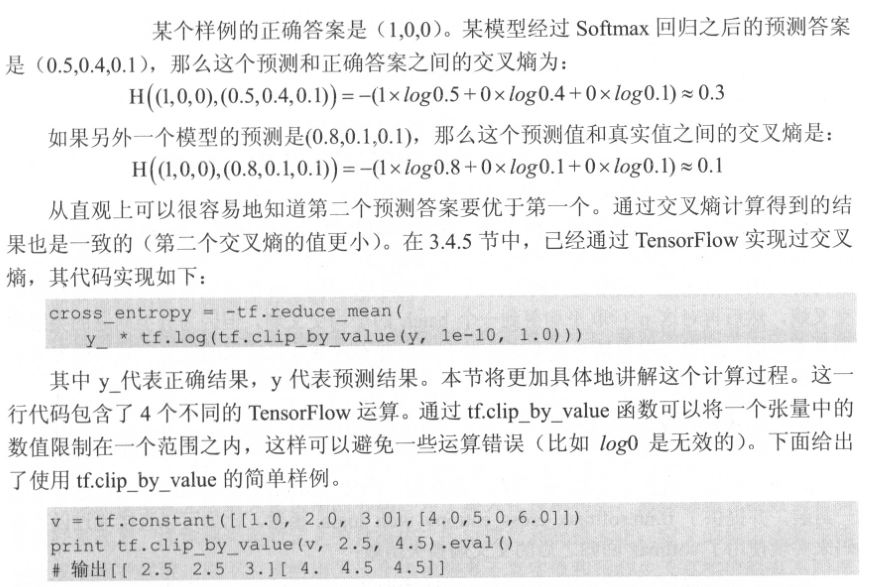

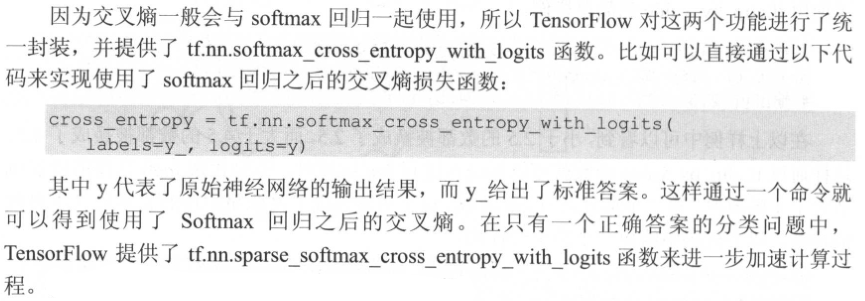

In [7]:
# 矩阵乘法比较
v1 = tf.constant([[1.0, 2.0], [3.0, 4.0]])
v2 = tf.constant([[5.0, 6.0], [7.0, 8.0]])

with tf.Session().as_default():
    # 矩阵对应元素相乘
    print((v1 * v2).eval())
    # 矩阵乘法
    print(tf.matmul(v1, v2).eval())

[[ 5. 12.]
 [21. 32.]]
[[19. 22.]
 [43. 50.]]


# 均方误差 - 回归问题
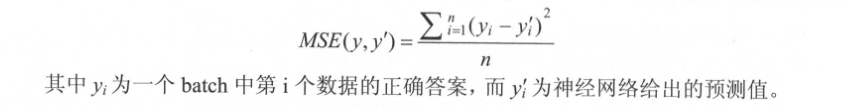

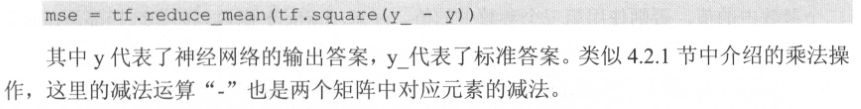

# 自定义损失函数

如对于有不同损失系数的损失函数：
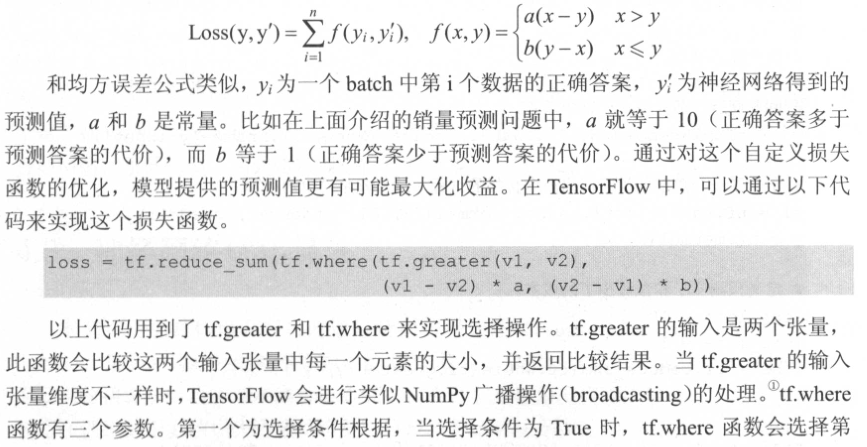
二个参数中的值，否则使用第三个参数中的值。注意tf.where函数判断和选择都是在元素级别进行。

In [8]:
# tf.where函数和tf.greater函数的用法
import tensorflow as tf

v1 = tf.constant([1.0, 2.0, 3.0, 4.0])
v2 = tf.constant([4.0, 3.0, 2.0, 1.0])

sess = tf.InteractiveSession()

# 相当于判断v1是否比v2大的函数
print(tf.greater(v1, v2).eval())

# if...else...判断函数
print(tf.where(tf.greater(v1, v2), v1, v2).eval())

sess.close()

[False False  True  True]
[4. 3. 3. 4.]


In [10]:
# 无隐藏层的神经网络
import tensorflow as tf
from numpy.random import RandomState

batch_size = 8

# 两个输入节点
x = tf.placeholder(tf.float32, shape=(None, 2), name='x-input')
# 回归问题一般只有一个输出节点
y_ = tf.placeholder(tf.float32, shape=(None, 1), name='y-input')

# 定义了一个单层的神经网络前向传播过程，这里是简单的加权和
w1 = tf.Variable(tf.random_normal([2, 1], stddev=1, seed=1))
y = tf.matmul(x, w1)

# 定义预测多了和预测少了的成本
loss_less = 10
loss_more = 1
loss = tf.reduce_sum(tf.where(tf.greater(y, y_),
                             (y - y_) * loss_more,
                             (y_ - y) * loss_less))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

# 通过随机数生成一个模拟数据集
rdm = RandomState(1)
dataset_size = 128
X = rdm.rand(dataset_size, 2)
# 设置回归的正确值为两个输入的和加上一个随机量
# 之所以加上一个随机量是为了加入不可预测的噪声，否则不同损失函数的意义就不大了
# 因为不同损失函数都会在能完全预测正确的时候最低
# 一般来说噪声为均值为0的常量，所以这里的噪声设置为-0.05~0.05的随机数
Y = [[x1 + x2 + rdm.rand()/10.0-0.05] for (x1, x2) in X]

# 训练神经网络
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    STEPS = 5000
    for i in range(STEPS):
        start = (i * batch_size) % dataset_size
        end = min(start + batch_size, dataset_size)
        sess.run(train_step,
                feed_dict={x: X[start:end], y_:Y[start:end]})
    print(sess.run(w1))

[[1.019347 ]
 [1.0428089]]


# 神经网络优化算法

神经网络的优化过程：

1、先通过前向传播算法计算得到的预测值，并将预测值和真实值做对比得出两者之间的差距

2、通过反向传播算法计算损失函数对每一个参数的梯度，再根据梯度和学习率使用梯度下降算法更新每一个参数

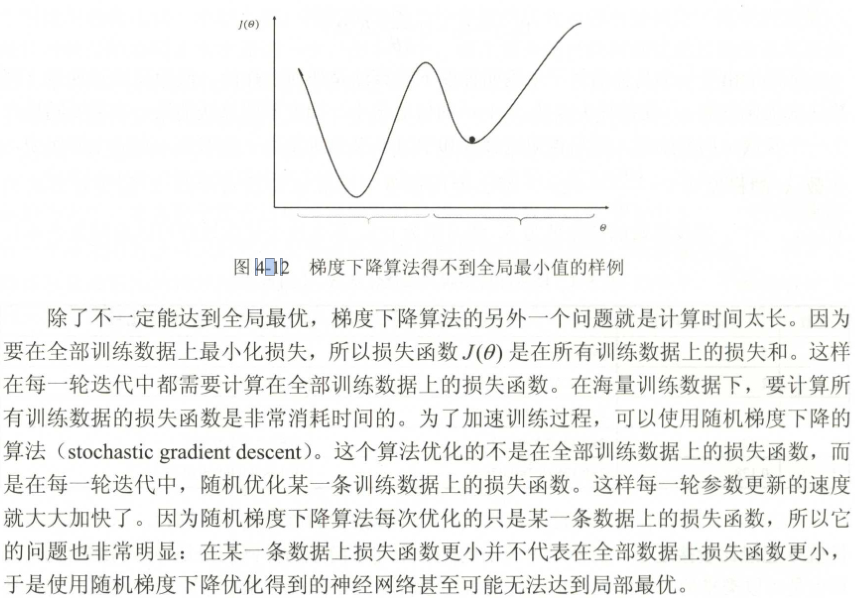

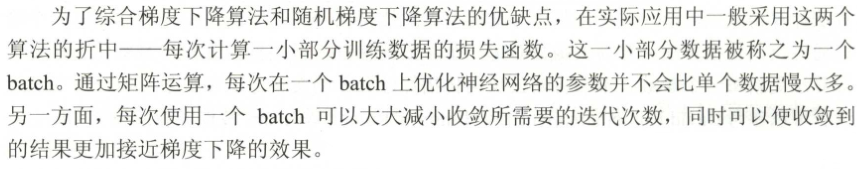

## 学习率

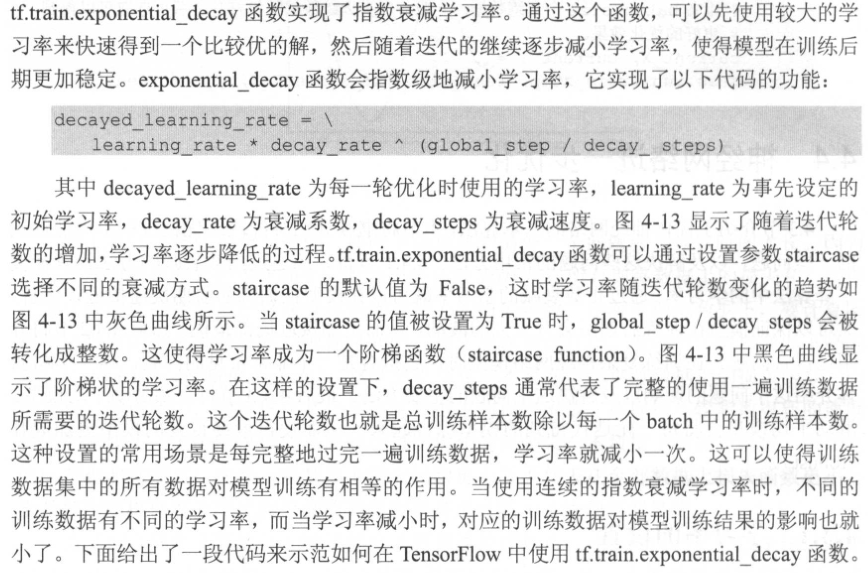

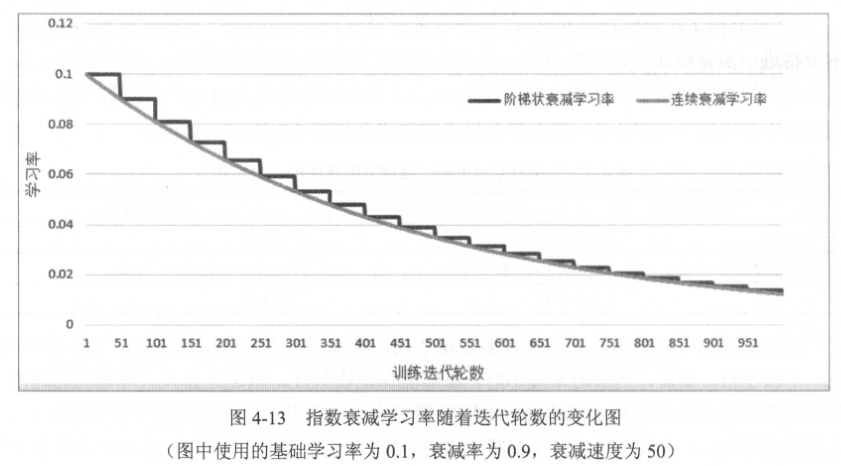

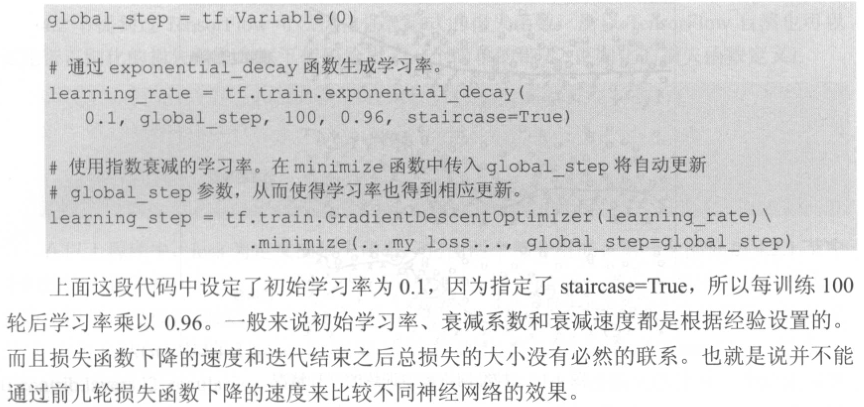

## 正则化

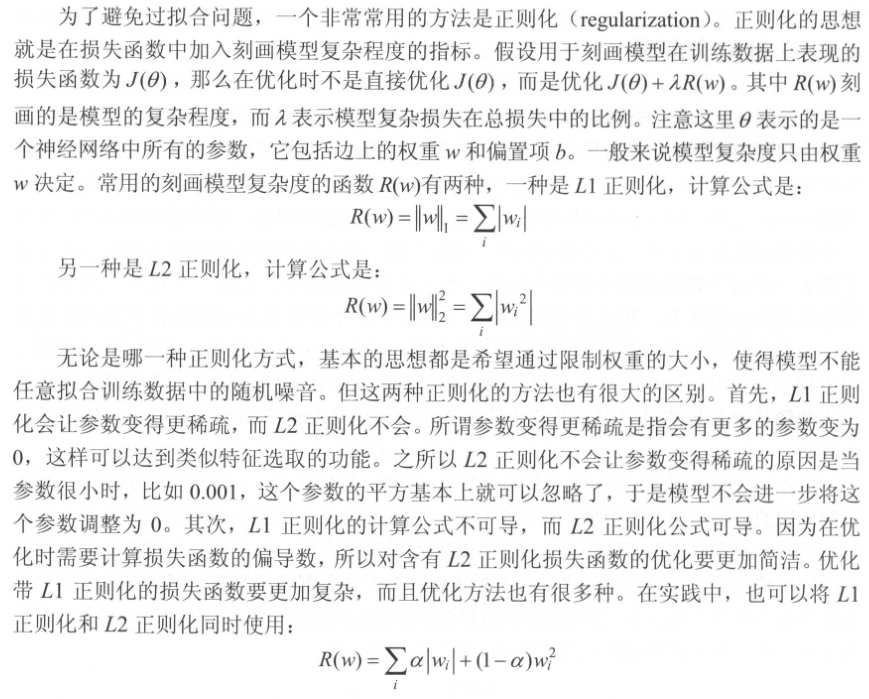

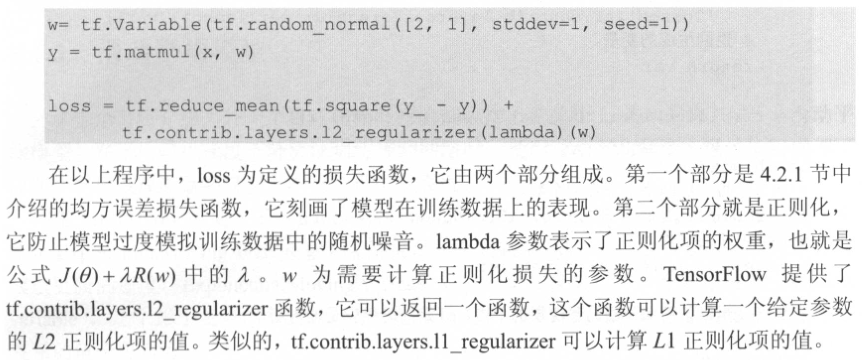

In [13]:
# 正则化样例
weights = tf.constant([[1.0, -2.0], [-3.0, 4.0]])
with tf.Session() as sess:
    # 输出为(|1| + |-2| + |-3| + |4|) × 0.5 = 5,其中0.5为正则化项的权重
    print(sess.run(tf.contrib.layers.l1_regularizer(.5)(weights)))
    # 输出为(|1|^2 + |-2|^2 + |-3|^2 + |4|^2) / 2 × 0.5 = 7.5
    print(sess.run(tf.contrib.layers.l2_regularizer(.5)(weights)))

5.0
7.5


In [16]:
# 通过集合计算一个5层神经网络带L2正则化的损失函数的计算方法
import tensorflow as tf

# 获取一层神经网络边上的权重，并将这个权重的L2正则化损失加入名称为'losses'的集合中
def get_weight(shape, _lambda):
    # 生成一个变量
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # add_to_collection函数将这个新生成变量的L2正则化损失项加入集合
    # 这个函数的第一个参数'losses'是集合的名字，第二个参数是要加入这个集合的内容
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(_lambda)(var))
    # 返回生成的变量
    return var

x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
batch_size = 8

# 定义每一层网络中节点的个数
layer_dimension = [2, 10, 10, 10, 1]
# 神经网络的层数
n_layers = len(layer_dimension)

# 这个变量维护前向传播时最深层的节点，开始的时候就是输入层
cur_layer = x
# 当前层的节点个数
in_dimension = layer_dimension[0]

# 通过一个循环来生成5层全连接的神经网络结构
for i in range(1, n_layers):
    # layer_dimension[i]为下一层的节点个数
    out_dimension = layer_dimension[i]
    # 生成当前层中权重的变量，并将这个变量的L2正则化损失加入计算图上的集合
    weight = get_weight([in_dimension, out_dimension], 0.001)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    # 使用ReLU激活函数
    cur_layer = tf.nn.relu(tf.matmul(cur_layer, weight) + bias)
    # 进入下一层之前将下一层的节点个数更新为当前层节点个数
    in_dimension = layer_dimension[i]
    
# 在定义神经网络前向传播的同时已经将所有的L2正则化损失加入了图上的集合
# 这里只需要计算刻画模型在训练数据上表现的损失函数
mse_loss = tf.reduce_mean(tf.square(y_ - cur_layer))

# 将均方误差损失函数加入损失集合
tf.add_to_collection('losses', mse_loss)

# get_collection返回一个列表，这个列表是所有这个集合中的元素。在这个样例中
# 这些元素就是损失函数的不同部分，将它们加起来就可以得到最终的损失函数
loss = tf.add_n(tf.get_collection('losses'))

## 滑动平均模型
在采用随机梯度下降算法训练神经网络时，使用滑动平均模型在很多应用中都可以在一定程度提高最终模型在测试数据上的表现

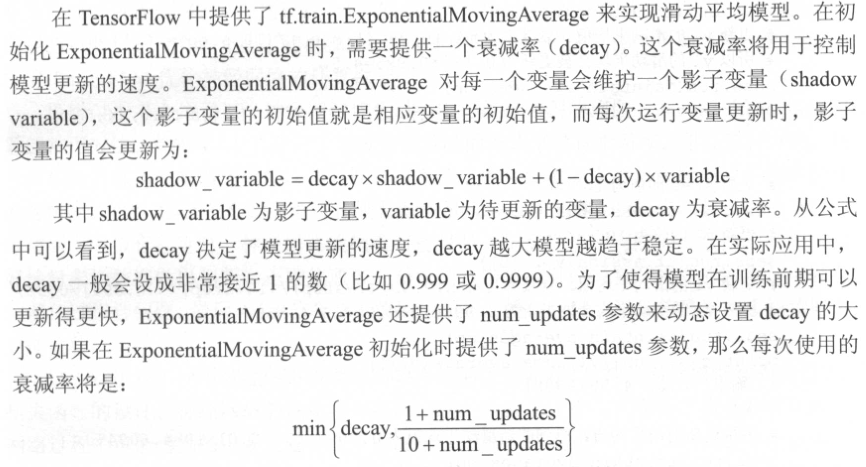

In [17]:
# ExponentialMovingAverage函数的使用
import tensorflow as tf

# 定义一个变量用于计算滑动平均，这个变量的初始值为0
# 注意所有需要计算滑动平均的变量必须是实数型
v1 = tf.Variable(0, dtype=tf.float32)

# step变量模拟神经网络中迭代的轮数，可以用于动态控制衰减率
step = tf.Variable(0, trainable=False)

# 定义一个滑动平均的类，初始化时给定了衰减率和控制衰减率的变量step
ema = tf.train.ExponentialMovingAverage(0.99, step)
# 定义一个更新变量滑动平均的操作，这里需要给定一个列表
# 每次执行这个操作时，这个列表中的变量都会被更新
maintain_averages_op = ema.apply([v1])

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # 通过ema.average(v1)获取滑动平均之后变量的取值
    # 在初始化之后变量v1的值和v1的滑动平均都为0
    print(sess.run([v1, ema.average(v1)]))
    
    # 更新变量v1的值到5
    sess.run(tf.assign(v1, 5))
    # 更新v1的滑动平均值。衰减率为min(0.99, (1+step)/(10+step)=0.1)=0.1
    # 所以v1的滑动平均会被更新为0.1×0+0.9×5=4.5
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))
    
    # 更新step的值为10000
    sess.run(tf.assign(step, 10000))
    # 更新v1的值为10
    sess.run(tf.assign(v1, 10))
    # 更新v1的滑动平均值。衰减率为min(0.99, (1+step)/(10+step)≈0.999)=0.99
    # 所以v1的滑动平均会被更新为0.99×4.5+0.01×10=4.555
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))
    
    # 再次更新滑动平均值，得到的滑动平均值为0.99×4.555+0.01×10=4.60945
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))

[0.0, 0.0]
[5.0, 4.5]
[10.0, 4.555]
[10.0, 4.60945]
